<a href="https://colab.research.google.com/github/DaeYejun2/PyTorch/blob/main/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_CIFAR_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
# 전처리 설정
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# 데이터 로드 및 확인
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


In [ ]:
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

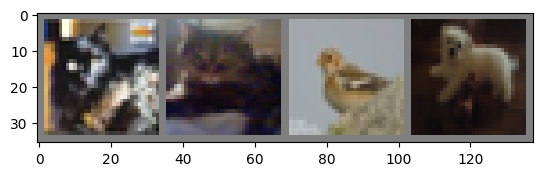

cat	 cat	 bird	 dog	


In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(classes[labels[j]]) for j in range(4)))

In [ ]:
# 신경망 구성
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# 모델 학습
for epoch in range(2):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print("Epoch: {}. Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

Epoch: 1. Batch: 2000, Loss: 2.22340791785717
Epoch: 1. Batch: 4000, Loss: 1.8671757738292216
Epoch: 1. Batch: 6000, Loss: 1.657039116859436
Epoch: 1. Batch: 8000, Loss: 1.5721755146086216
Epoch: 1. Batch: 10000, Loss: 1.510321531638503
Epoch: 1. Batch: 12000, Loss: 1.4588039783090354
Epoch: 2. Batch: 2000, Loss: 1.37781295786798
Epoch: 2. Batch: 4000, Loss: 1.3567542427480221
Epoch: 2. Batch: 6000, Loss: 1.3015370293334128
Epoch: 2. Batch: 8000, Loss: 1.2937363963071258
Epoch: 2. Batch: 10000, Loss: 1.2861468716189266
Epoch: 2. Batch: 12000, Loss: 1.250463198289275


In [ ]:
# 모델의 저장 및 로드
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

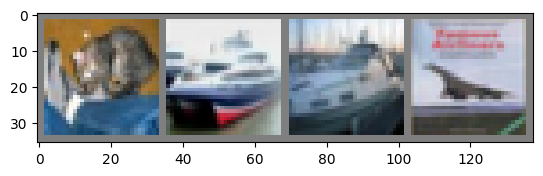

	cat 	ship 	ship 	plane


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range  (4)))

In [ ]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# 모델 테스트
outputs = net(images.to(device))

In [ ]:
_, predicted = torch.max(outputs, 1)
print(' '.join('\t{}'.format(classes[predicted[j]]) for j in range(4)))

	cat 	ship 	ship 	plane


In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(100 * correct / total)

56.42


In [ ]:
# 어떤 것을 잘 분류했고, 잘 못했는지 확인
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
for i in range(10):
  print("Accuracy of {}: {}%".format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 55.0%
Accuracy of car: 61.2%
Accuracy of bird: 30.2%
Accuracy of cat: 34.9%
Accuracy of deer: 36.2%
Accuracy of dog: 60.2%
Accuracy of frog: 73.1%
Accuracy of horse: 62.8%
Accuracy of ship: 76.7%
Accuracy of truck: 73.9%
